# **비흡연자를 컬럼별로 분석 및 시각화 해보기**

In [31]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

In [32]:
# 1. 데이터 로드
HOME = os.getcwd()
datapath = os.path.join(HOME)
data = pd.read_csv(os.path.join(datapath, 'data/insurance.csv'))
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
# heatmap 보기 전 범주형 데이터 변환
# 성별(sex), 지역(region), 흡연여부(smoker)를 한 번에 변환
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)
# drop_first=True는 '남/여' 중 '여'가 0이면 당연히 '남'이므로 열 하나를 삭제해 용량을 줄입니다.
data_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [47]:

# True/False로 되어 있는 컬럼 이름들만 리스트로 만듭니다.
target_cols = ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

# 해당 컬럼들만 int로 변환
data_encoded[target_cols] = data_encoded[target_cols].astype(int)
data_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [35]:
# 이상치 5명 삭제
outliers = [62,115,242,387,936]

data_final = data_encoded.drop(index=outliers)

print(f"데이터 삭제 전 갯수 : {len(data)}")
print(f"데이터 삭제 후 갯수 : {len(data_final)}")
print(f"삭제된 인덱스가 아직 남아있는가? {any(i in data_final.index for i in outliers)}")

데이터 삭제 전 갯수 : 1338
데이터 삭제 후 갯수 : 1333
삭제된 인덱스가 아직 남아있는가? False


In [36]:
data_final.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,0,False,1,False,0,0,1
1,18,33.770,1,1725.55230,False,1,True,0,False,0,1,0
2,28,33.000,3,4449.46200,False,1,True,0,False,0,1,0
3,33,22.705,0,21984.47061,False,1,True,0,False,1,0,0
4,32,28.880,0,3866.85520,False,1,True,0,False,1,0,0


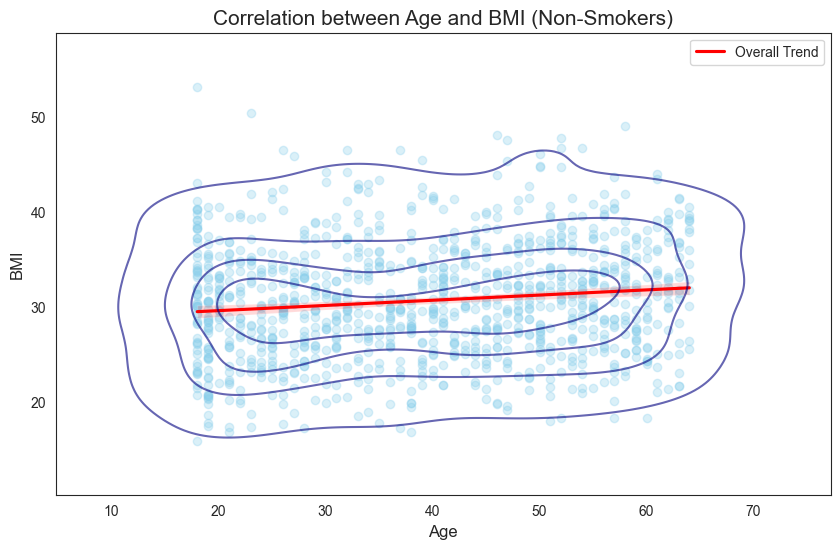

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 시각화 스타일 설정
sns.set_style("white")
plt.figure(figsize=(10, 6))

# 2. 비흡연자 데이터 필터링 (가장 깨끗한 패턴 확인을 위해)
non_smoker_df = data_final[data_final['smoker_yes'] == 0]

# 3. 산점도와 밀도 그래프(KDE)를 결합
# - 점(Scatter)은 실제 데이터를 보여주고
# - 등고선(levels)은 데이터가 집중된 정도를 100, 200... 단위처럼 시각화합니다.
sns.regplot(data=non_smoker_df, x='age', y='bmi', 
            scatter_kws={'alpha':0.3, 'color':'skyblue'}, 
            line_kws={'color':'red', 'label':'Overall Trend'})

sns.kdeplot(data=non_smoker_df, x='age', y='bmi', 
            levels=5, color="navy", alpha=0.6, label='Density levels')

# 4. 그래프 꾸미기
plt.title("Correlation between Age and BMI (Non-Smokers)", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("BMI", fontsize=12)
plt.legend()

plt.show()

## **실제 BMI 수치는 100이나 200까지 올라갈 수 없기때문에 지나치게 작게 축소는불가능 또한 그래프로 시각화할시 데이터가 안보임**

### **비흡연자 그룹 분석 결과, 연령이 증가함에 따라 BMI 수치가 미세하게 동반 상승하는 경향을 확인하였으며, 이는 비흡연자 고연령층의 의료비 증가를 설명하는 요인으로 판단됨**

### **그래프로 봤을때 회귀선 테투리로 미세한 흐릿한 경계가 보입니다 이 경계가 신뢰구간인데, 이는 모델의 예측값이 실제값과 얼마나 가까운지를 나타내며, 양쪽 끝은 흐릿한부분이 두꺼운 반면 가운데는 아주 얇은데, 얇을수록 데이터가 많다는 뜻입니다<br>**
### **즉 어디에 데이터가 몰려있는지를 알수 있는 부분입니다  age는 30~50 대, bmi는 27~33정도 사이에 몰려있음을 알수있습니다** 

In [38]:
print(non_smoker_df.columns)

Index(['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male',
       'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')


<Figure size 800x600 with 0 Axes>

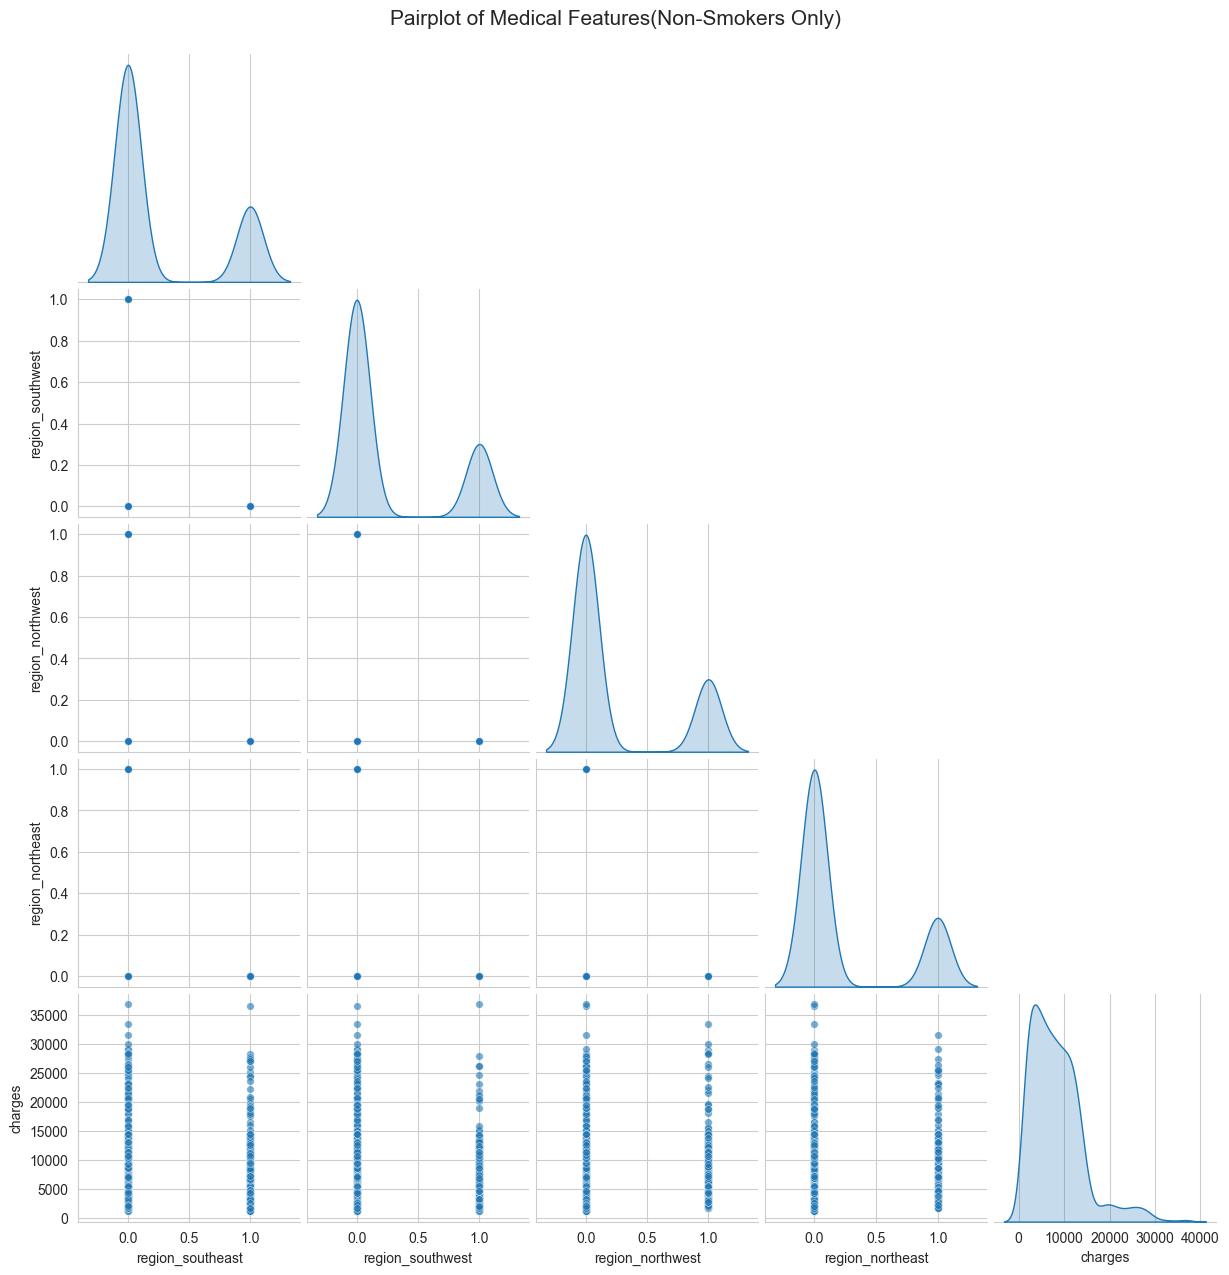

In [44]:
# 비흡연자의 상관성을 region과 charges를 pairplot 이용하여 한 눈에 보기

non_smoker_df = data_final[data_final['smoker_yes'] == 0].copy()

# 분석에 필요한 주요컬럼들 선택 너무 많으면 그래프가 작아짐
cols = ['region_southeast', 'region_southwest', 'region_northwest','region_northeast','charges']
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')

# diag_kind='kde'는 대각선에 분포를 부드러운 곡선으로 그려줍니다.
# plot_kws={'alpha': 0.5}는 점들이 겹쳐도 잘 보이게 투명도를 조절합니다.
g = sns.pairplot(non_smoker_df[cols],
                 diag_kind='kde',
                 plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'w'},
                 corner=True)# 중복되는 위쪽 삼각형은 가리는 코드

g.fig.suptitle('Pairplot of Medical Features(Non-Smokers Only)', y=1.02, fontsize=15)

plt.show()

# 20,000달러 이상의 고액 구간에서 지역별 비흡연자가 많이 관찰되는 현상
### **비흡연자 절대 수의 우위**와 **특정 위험 요인의 결합**이라는 두 가지 원인이 복합적으로 작용하고 있는걸 확인
* 인구 통계적 원인: 비흡연자 비율의 압도적 우위로서 단지 비흡연자가 많기때문에 고액구간에서 높게 발견됨
* 그래프에서 고액 구간을 보면, 비흡연자임에도 불구하고 높은 비용이 발생하는 사례가 지역을 가리지 않고 고르게 확인됨
* 이는 앞서 분석했던 "비흡연자 + 고령 + 고BMI" 혹은 **비흡연자 + 많은 자녀 수**와 같은 요인들이 지역적 특성(지역별 기본 수가 차이 등)과 결합했을 때, 흡연 여부와 상관없이 20,000달러라는 심리적 마지노선을 쉽게 넘기게 만드는 원인이 됩니다.
* 정상 체중이라도 자녀가 많거나 고연령일 경우 상단 그룹으로 이동하며, 비만이라도 나이가 아주 젊으면 하단 그룹에 머무는 등 변수 간의 유기적인 결합이 비용을 결정합니다.

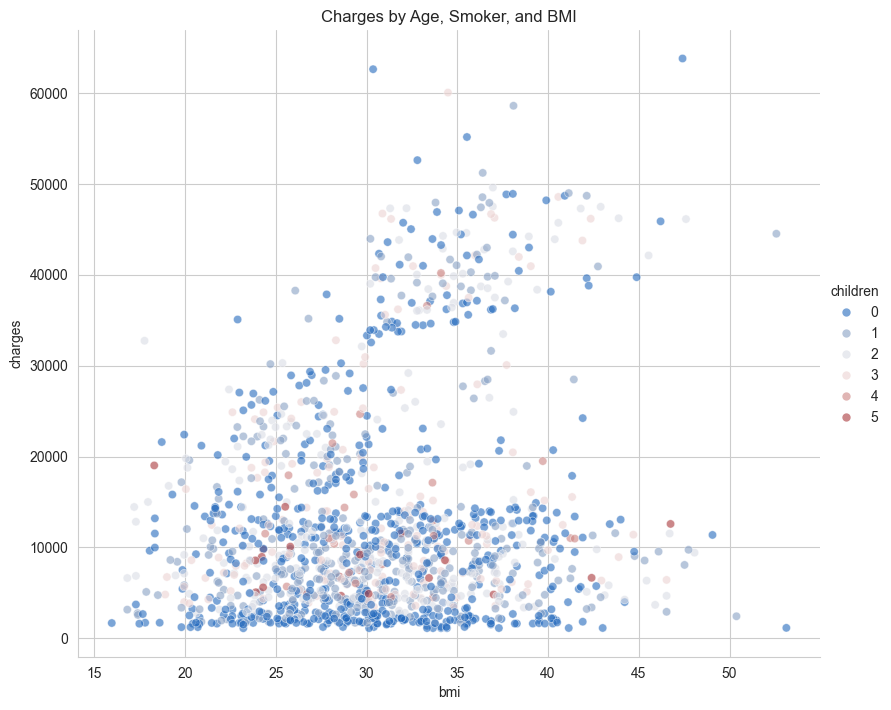

In [45]:
sns.relplot(data=data,x='bmi', y='charges', hue='children',
    sizes=(20, 200), # 점 크기 범위 설정
    alpha=0.6,      # 점이 겹쳐도 보이게 투명도 조절
    palette='vlag',  # 색상 테마
    height=7, 
    aspect=1.2)

plt.title('Charges by Age, Smoker, and BMI')
plt.show()

### 이 그래프는 20,000달러 이상의 비흡연자/지역별/고액 납부자가 넓게 분포해있는걸 토대로 다른 원인이있는지 자녀수와 비교하여 만들었음
### 결과 : 자녀수와bmi에 상관없이 다양하게 저액,고액에 분포되어있는걸 확인 
### **이 그래프에서 children은 연관성이 없다 판단하여 분석에서 제외하였습니다**

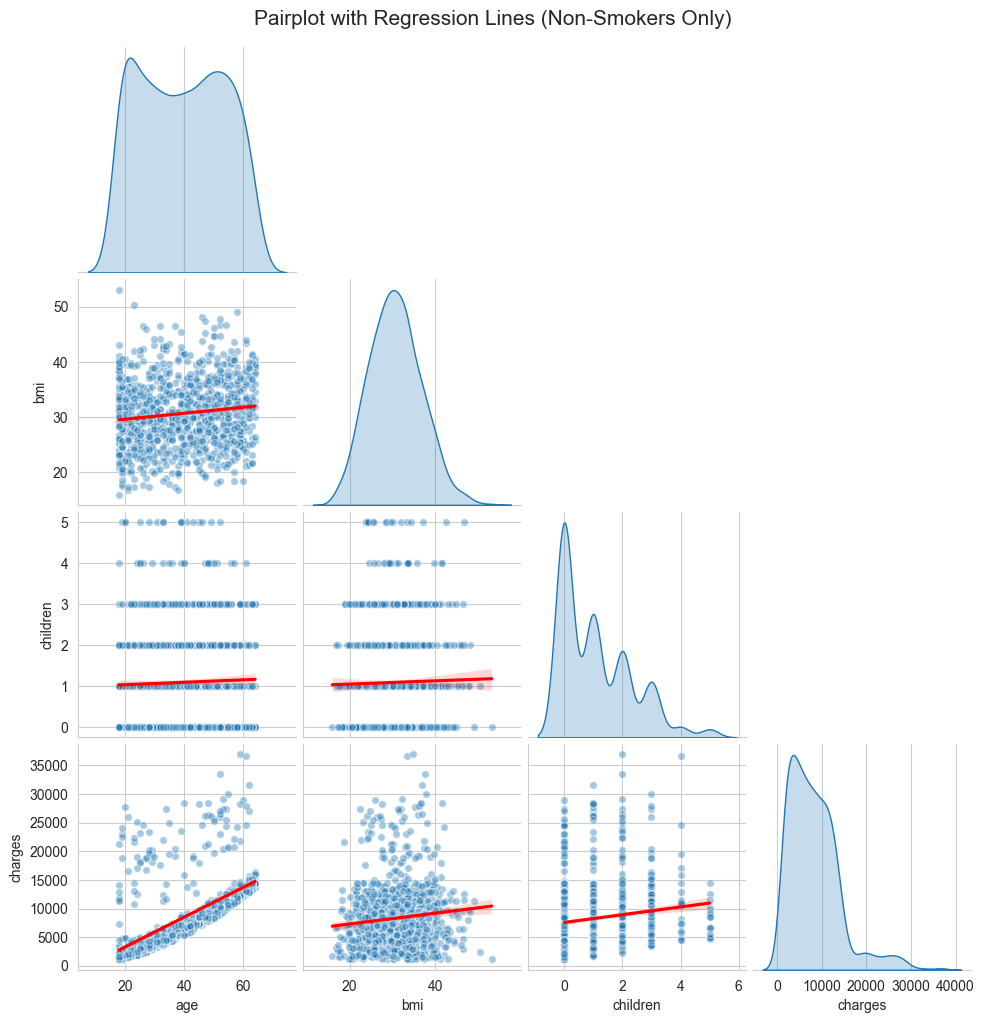

In [41]:
# # 비흡연자의 상관성을 각 컬럼별 그래프로 pairplot 이용하여 한 눈에 보기

non_smoker_df = data_final[data_final['smoker_yes'] == 0].copy()

# 분석에 필요한 주요컬럼들 선택
cols = ['age', 'bmi', 'children', 'charges']
sns.set_style('whitegrid')

# kind='reg' 를 추가하면 산점도 위에 회귀선(기울기)이 그려집니다.
g = sns.pairplot(non_smoker_df[cols],
                 kind='reg', # 회귀선 추가
                 diag_kind='kde',
                 plot_kws={
                     'line_kws':{'color':'red'}, # 기울기 선을 빨간색으로
                     'scatter_kws':{'alpha': 0.4, 's': 30, 'edgecolor': 'w'} # 점 설정
                 },
                 corner=True)

g.fig.suptitle('Pairplot with Regression Lines (Non-Smokers Only)', y=1.02, fontsize=15)

plt.show()

### 1. 위 그래프를 통해 smoker_yes==0인 경우 children은 전혀 상관이없으며, bmi와age의 상관관계가 미세하게 우상향하는걸 확인
### 2. charges와 charges에서 두구간으로 나뉘는걸 확인
### 3. bmi와age의 데이터분포 및 다양하게 시각화 하여 어느정도 상관지수가 있는지 확인
### 4. charges와 charges에서 누구간으로 나뉘는 원인 확인

**"비흡연자 그룹 내에서도 BMI 30을 기점으로 보험료 할증 계수가 다르게 적용되는 구간이 존재한다"**

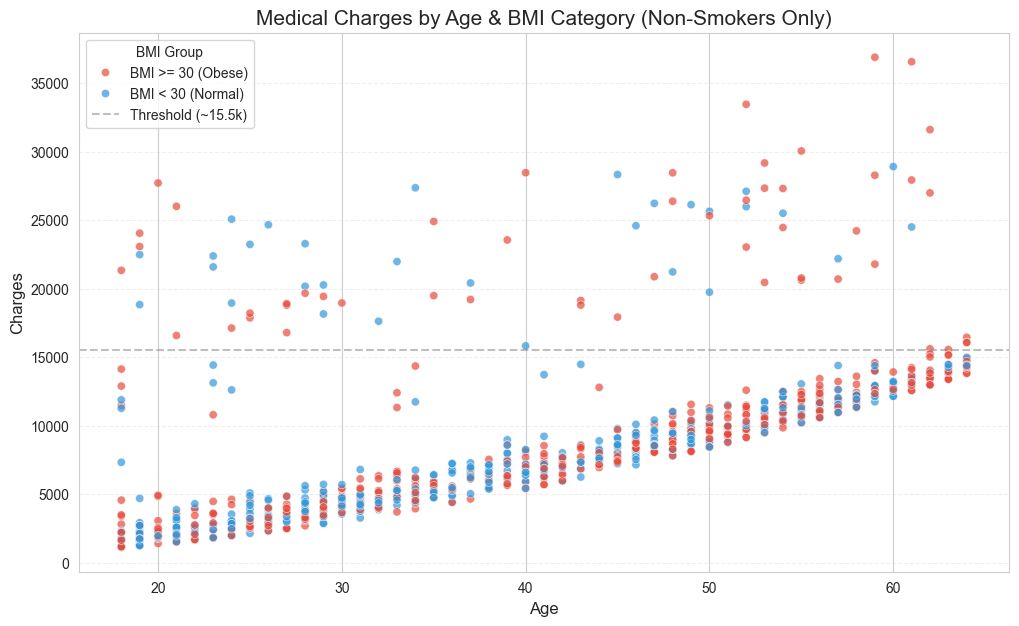

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 비흡연자 데이터 필터링
non_smoker_df = data_final[data_final['smoker_yes'] == 0].copy()

# 2. BMI 30을 기준으로 그룹 생성 (비만 여부)
non_smoker_df['bmi_group'] = non_smoker_df['bmi'].apply(lambda x: 'BMI >= 30 (Obese)' if x >= 30 else 'BMI < 30 (Normal)')

# 3. 시각화
plt.figure(figsize=(12, 7))
sns.scatterplot(data=non_smoker_df, 
                x='age', 
                y='charges', 
                hue='bmi_group', 
                palette={'BMI >= 30 (Obese)': '#e74c3c', 'BMI < 30 (Normal)': '#3498db'},
                alpha=0.7)

# 4. 경계선 표시 (질문하신 15,000~16,000 구간)
plt.axhline(y=15500, color='gray', linestyle='--', alpha=0.5, label='Threshold (~15.5k)')

plt.title("Medical Charges by Age & BMI Category (Non-Smokers Only)", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Charges", fontsize=12)
plt.legend(title="BMI Group")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

### 간혹 파란색인데 위에 있거나 빨간색인데 아래에 있는 점들은 가족 수(children)나 지역(region) 등의 다른 변수가 영향을 준 경우입니다. 하지만 위에서 보여졌듯이 자녀수와 지역은 관계가 없는것으로 판단  비흡연자 그룹 내 '제3의 변수' 존재 (데이터에 없는 원인)가 있는것으로 확인되었음
### 비흡연자 집단에서 15,500달러 이상의 고액 구간에 파란 점(BMI < 30)이 많다는 것 또한, 비만이 아니더라도 보험료를 폭발적으로 높이는 이 데이터에 없는 다른 요인이 있다는 증거입니다.
### 이는 선형 회귀 모델의 오차를 유발하는 주요 원인이었으며, 트리 기반 모델(RandomForest)이 이를 조건 분기(Node Splitting)를 통해 성공적으로 학습하여 높은 성능을 낼 수 있었던 핵심 이유입니다

C:\Users\june4\AppData\Local\Temp\ipykernel_4468\4253648876.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = temp_df.pivot_table(values='charges', index='bmi_bin', columns='age_bin', aggfunc='mean')


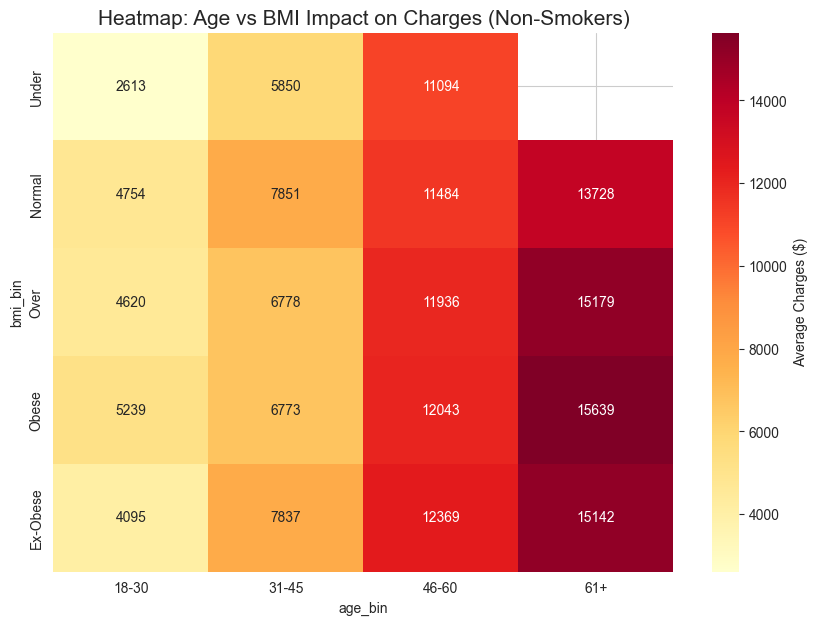

In [56]:
# 나이와 BMI를 구간별로 나누기
temp_df = data_final[data_final['smoker_yes'] == 0].copy()
temp_df['age_bin'] = pd.cut(temp_df['age'], bins=[18, 30, 45, 60, 65], labels=['18-30', '31-45', '46-60', '61+'])
temp_df['bmi_bin'] = pd.cut(temp_df['bmi'], bins=[0, 18.5, 25, 30, 35, 60], labels=['Under', 'Normal', 'Over', 'Obese', 'Ex-Obese'])

# 히트맵을 위한 피벗 테이블 생성 (평균 보험료)
pivot_table = temp_df.pivot_table(values='charges', index='bmi_bin', columns='age_bin', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={'label': 'Average Charges ($)'})
plt.title('Heatmap: Age vs BMI Impact on Charges (Non-Smokers)', fontsize=15)
plt.show()

### 비흡연자라도 '61세 이상 + 비만' 구간에 진입하면 색깔이 급격히 진해집니다. 두 리스크가 만나는 지점을 모델이 어떻게 학습했는지 보여주는 지표입니다.

C:\Users\june4\AppData\Local\Temp\ipykernel_4468\3710815156.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


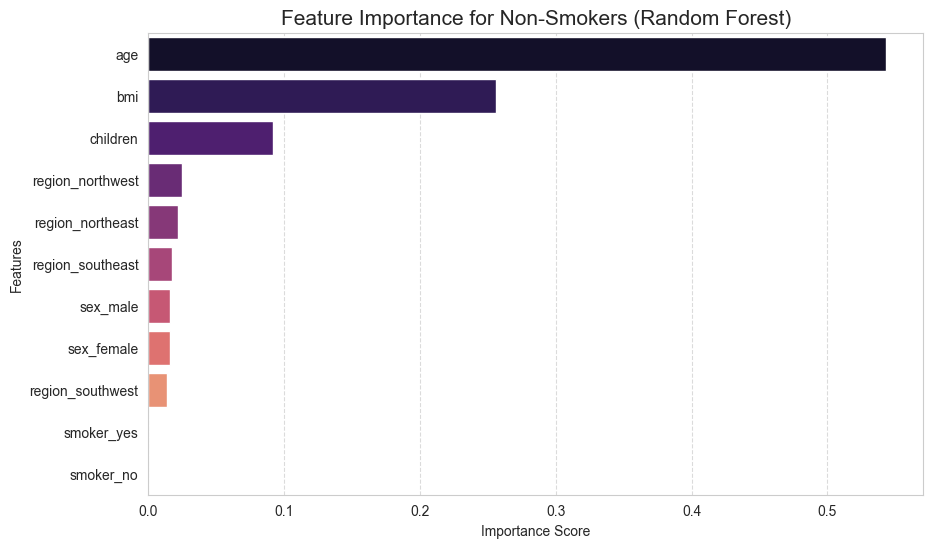

In [49]:
from sklearn.ensemble import RandomForestRegressor

# 1. 비흡연자 데이터 준비 (이미 전처리가 완료된 data_final 사용 가정)
# 'charges'를 제외한 나머지를 특성(X), 'charges'를 타겟(y)으로 설정
non_smoker_data = data_final[data_final['smoker_yes'] == 0]
X = non_smoker_data.drop(['charges'], axis=1)
y = non_smoker_data['charges']

# 2. 모델 학습 (중요도를 뽑기 위해 간단히 학습)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 3. 변수 중요도 추출 및 정렬
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')

plt.title('Feature Importance for Non-Smokers (Random Forest)', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 비흡연자에 관해선 age가 가장 큰 영향을 미친다.

### **최종**
* 보험료 산정은 단일 지표(나이 혹은 흡연)만으로 판단할 수 없는 다층적 구조를 가집니다.
* 비흡연자라 하더라도 나이에 따른 BMI 관리가 이루어지지 않으면 고액 의료비 집단(15k~25k)으로 편입될 확률이 매우 높습니다.
* 모델링 측면에서는 **다항 회귀(Polynomial)** 나 앙상블 기법을 활용해 변수 간의 **상호작용(Interaction)** 을 포착하는 것이 정확한 예측의 핵심입니다.

### 선형 모델(Linear) vs 앙상블 모델(RandomForest, XGBoost): 
* 단순 선형 회귀는 0.50 수준의 낮은 $R^2$ 점수를 보인 반면, 앙상블 모델은 0.97이라는 압도적인 성능을 기록했습니다.원인: 의료비 데이터는 단순히 '나이가 들면 오른다'는 선형적 구조가 아니라, 비만(BMI 30↑) + 흡연 여부에 따라 비용이 수직 상승(계단식 상승)하는 비선형적 구조를 가지고 있기 때문입니다. 앙상블 모델은 이러한 '복잡한 조건문'을 스스로 학습하는 데 탁월했습니다.